# Echo State Network as a tunable frequency generator

This is a simplified implementation of Herbert Jaeger's task of learning a simple non-autonomous system, [a frequency generator controlled by an external signal](http://www.scholarpedia.org/article/Echo_state_network). Plots at the end.

[See the ESN implementation](https://github.com/cknd/pyESN).


In [1]:
import numpy as np
%matplotlib notebook
from matplotlib import pyplot as plt
%matplotlib inline
from pyESN import ESN
from sklearn.model_selection import train_test_split
from Loader import Loader
import torch

In [2]:
random_state = 42

## Task

The network will learn to generate a wave signal whose frequency is determined by some slowly changing control input.

#### 1) Generate some sample data:


In [3]:
threshold = 1000
def get_mask(u, y):
    u_tensor = torch.tensor(u)
    y_tensor = torch.tensor(y)

    # Identify indices with NaNs
    nan_mask = torch.isnan(u_tensor).any(dim=(1, 2)) | torch.isnan(y_tensor).any(dim=(1, 2))
    nan_samples_count = nan_mask.sum().item()

    # Identify indices where max y exceeds threshold
    max_y_values = y_tensor.max(dim=2).values.max(dim=1).values
    threshold_mask = max_y_values <= threshold
    large_samples_count = (~threshold_mask).sum().item()

    # Combine masks
    valid_mask = ~nan_mask & threshold_mask
    return valid_mask, nan_samples_count, large_samples_count

In [38]:
datapath = '../NIEMRE_Feb20_2025/Hodgkin_Huxley/data/'
loader = Loader()
loader.mount(datapath)
A_list = [i for i in range(20, 150, 30)]
fc_list = [i for i in range(10, 1100, 100)]
fm_list = [i for i in range(10, 61, 10)]
data = loader.load_db(
            A_list=A_list,
            fc_list=fc_list,
            fm_list=fm_list
        )
u, y, p = data[0], data[1], data[3]

total_samples = u.shape[0]
mask, nan_samples_count, large_samples_count = get_mask(u, y)

print(f'Total samples before filtering: {total_samples}')
print(f'Samples containing NaN: {nan_samples_count}')
print(f'Samples exceeding threshold {threshold}: {large_samples_count}')

# Apply mask
u, y, p = u[mask.numpy()], y[mask.numpy()], p[mask.numpy()]

# Recalculate after filtering
total_samples_after = u.shape[0]

print(f'Total samples after filtering: {total_samples_after}')

Loader successfully mounted to the directory: ../NIEMRE_Feb20_2025/Hodgkin_Huxley/data/
Metadata successfully mounted to: ../NIEMRE_Feb20_2025/Hodgkin_Huxley/data/metadata
Total samples before filtering: 330
Samples containing NaN: 0
Samples exceeding threshold 1000: 0
Total samples after filtering: 330


In [39]:
u.shape

(330, 4, 5000)

In [40]:
p.shape

(330, 3)

In [41]:
p[0]

array([20, 10, 10])

In [42]:
intervals = [i * u.shape[2] for i in range(p.shape[0] + 1)]

In [43]:
u_train,u_test, y_train, y_test, p_train, p_test = train_test_split(
    u, y, p, test_size=0.3, random_state=random_state)

In [44]:
p_train.shape

(231, 3)

In [45]:
train_intervals = [i * u.shape[2] for i in range(p_train.shape[0] + 1)]

In [46]:
test_intervals = [i * u.shape[2] for i in range(p_test.shape[0] + 1)]

In [47]:
train_intervals[-1]

1155000

In [48]:
test_intervals[-1]

495000

In [49]:
data_list = [u_train,u_test, y_train, y_test]

In [50]:
len(u_train[0,3,:1000])

1000

In [51]:
u_train[0,3,:1000].shape

(1000,)

In [52]:
y_train.shape

(231, 1, 5000)

In [53]:
y_train[0, 0, :1000].shape

(1000,)

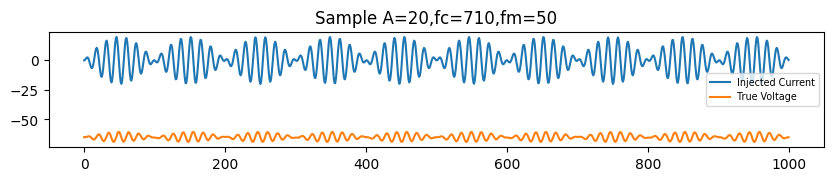

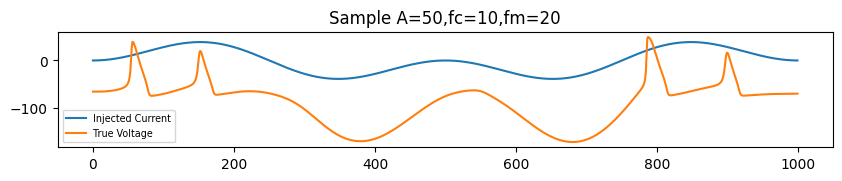

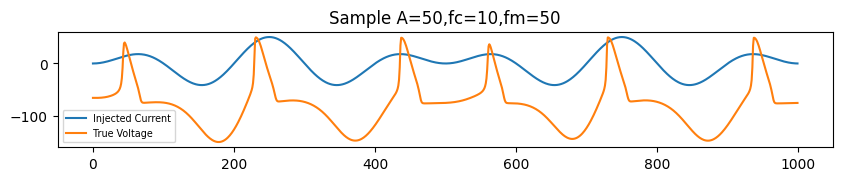

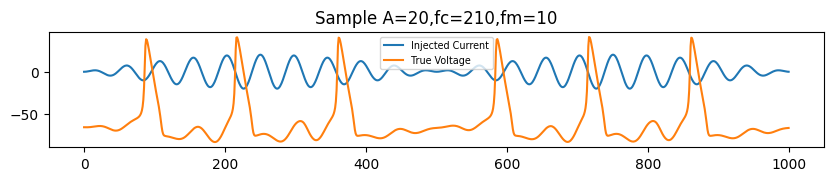

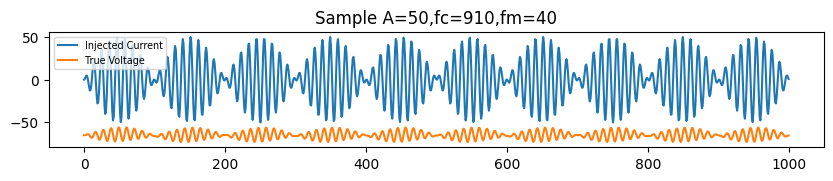

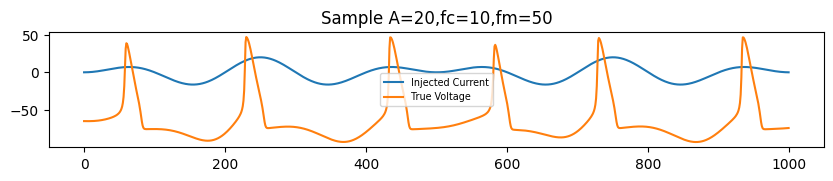

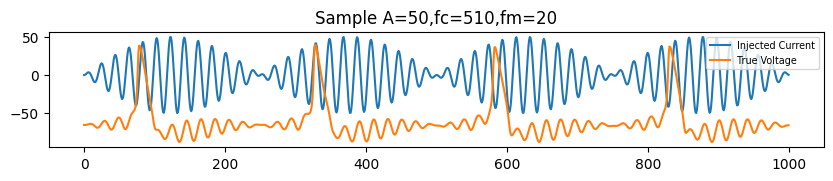

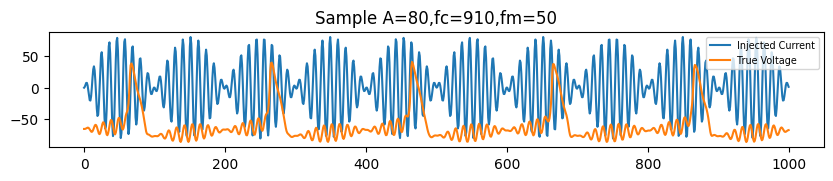

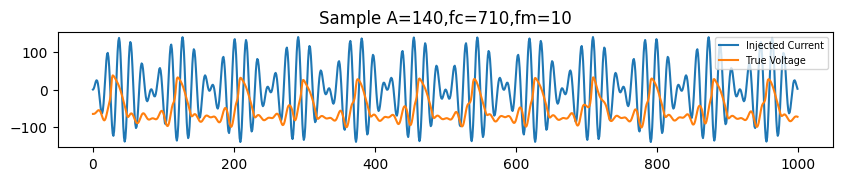

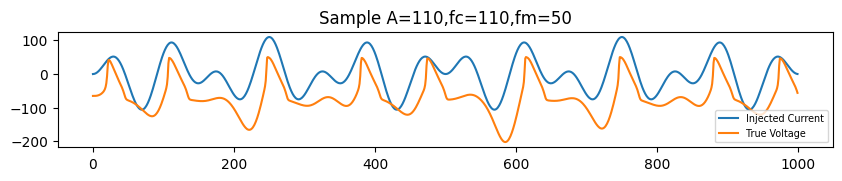

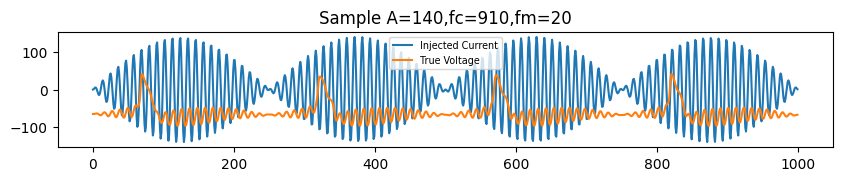

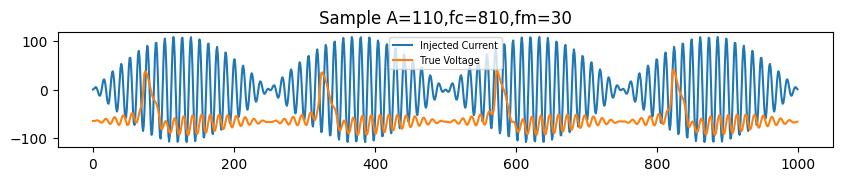

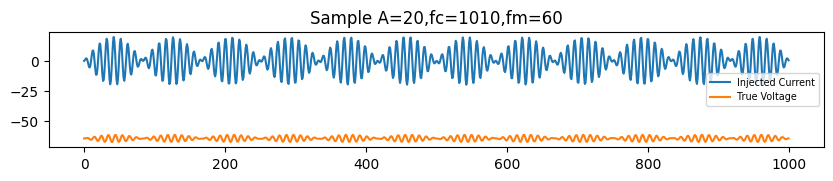

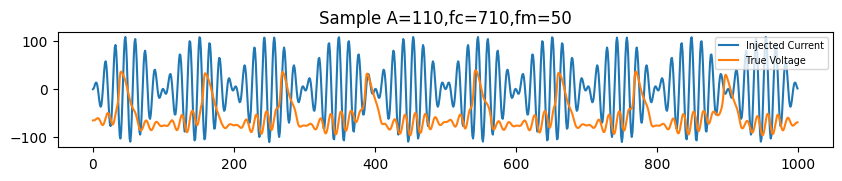

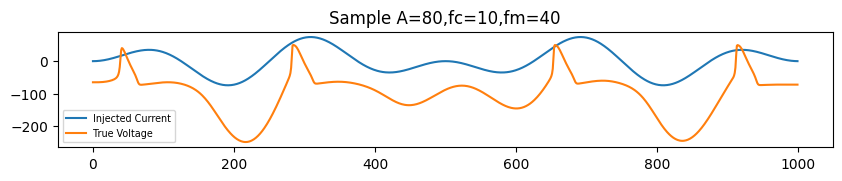

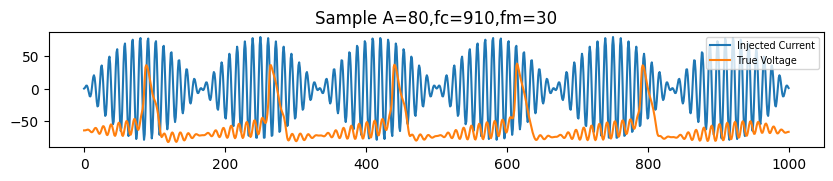

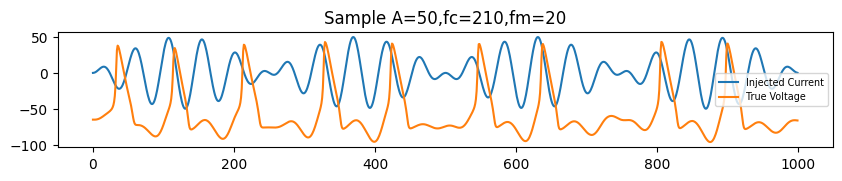

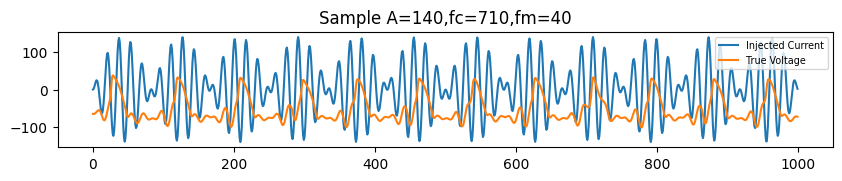

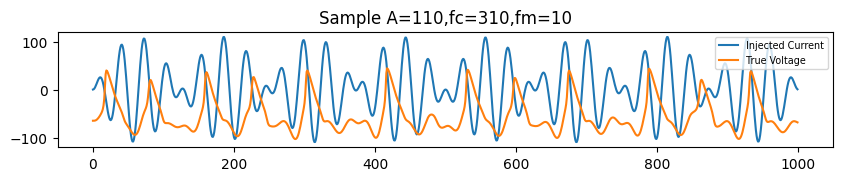

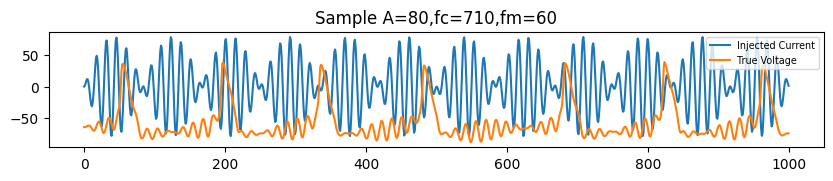

In [54]:
for i, (u_, y_, p_) in enumerate(zip(u_train, y_train, p_train)):
    if i >= 20:  # Show only first 5 plots
        break
    plt.figure(figsize=(10,1.5))
    plt.plot(u_[3,:1000],label='Injected Current')
    plt.plot(y_[0, :1000],label='True Voltage')
    plt.legend(fontsize='x-small')
    plt.title(f'Sample A={p_[0]},fc={p_[1]},fm={p_[2]}')
    #plt.ylim([-0.1,1.1])
    plt.show()

In [55]:
u_train.flatten().shape

(4620000,)

In [35]:
for i, d in enumerate(data_list):
    # Reshape from (samples, features, time) -> (time, samples, features)
    d = d.transpose(2, 0, 1)
    
    # Flatten (time, samples, features) -> (time * samples, features)
    d = d.reshape(d.shape[0] * d.shape[1], d.shape[2])
    
    
    # Assign back to the list
    data_list[i] = d  

    # Optional: Print the shape for debugging
    print(f"Updated shape of data_list[{i}]: {d.shape}")

Updated shape of data_list[0]: (1155000, 4)
Updated shape of data_list[1]: (495000, 4)
Updated shape of data_list[2]: (1155000, 1)
Updated shape of data_list[3]: (495000, 1)


In [36]:
u_train,u_test, y_train, y_test = data_list[0], data_list[1], data_list[2], data_list[3]  

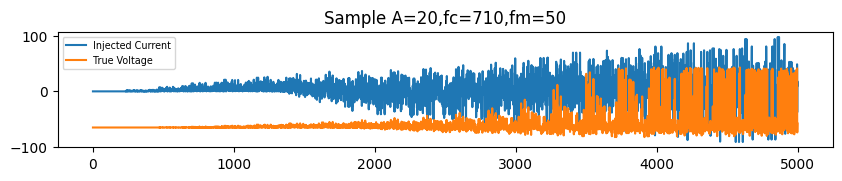

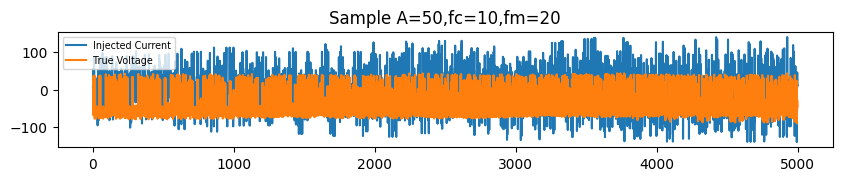

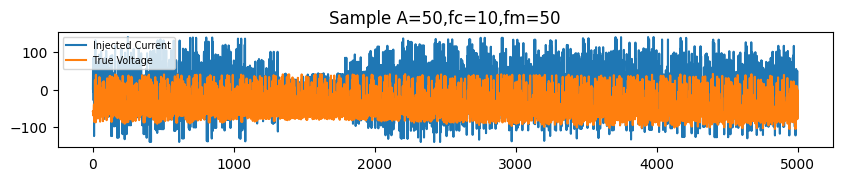

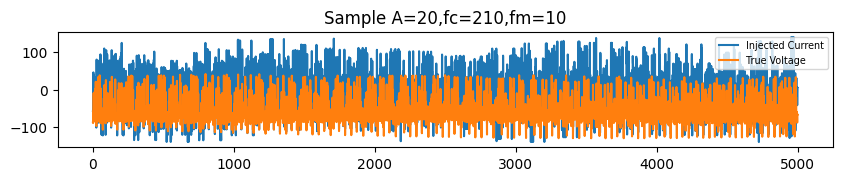

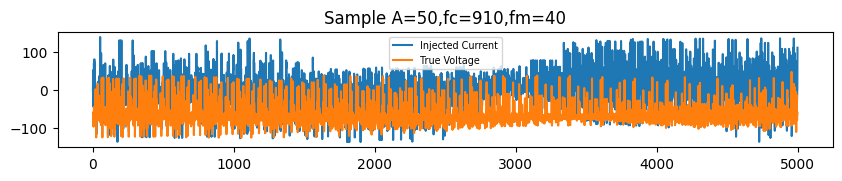

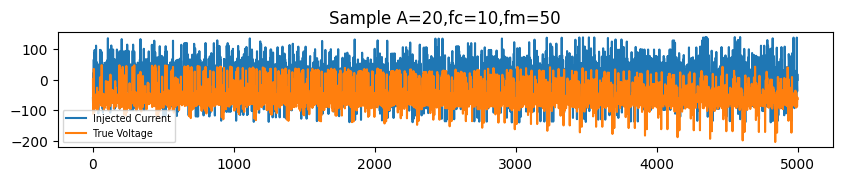

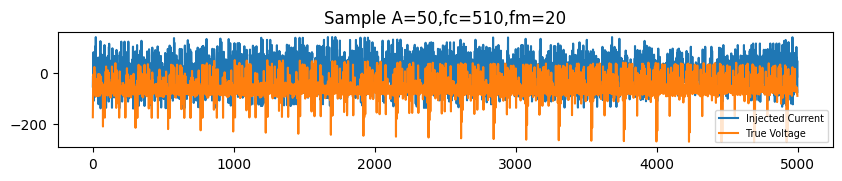

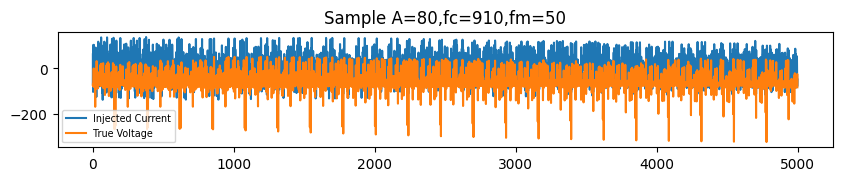

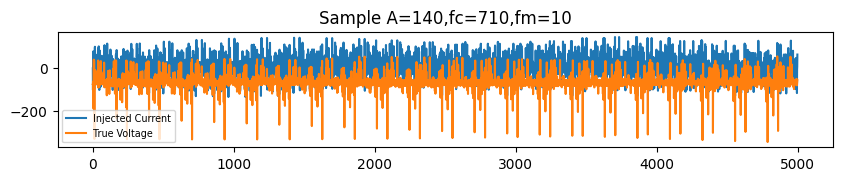

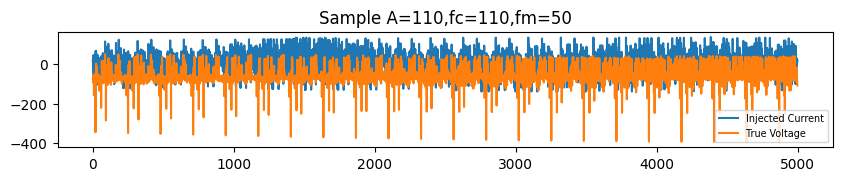

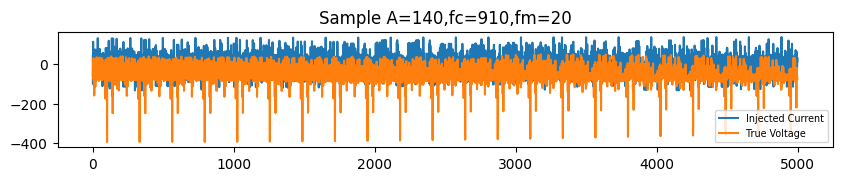

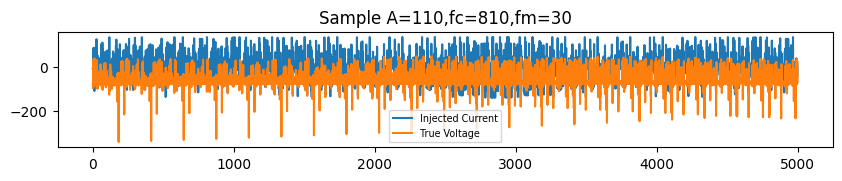

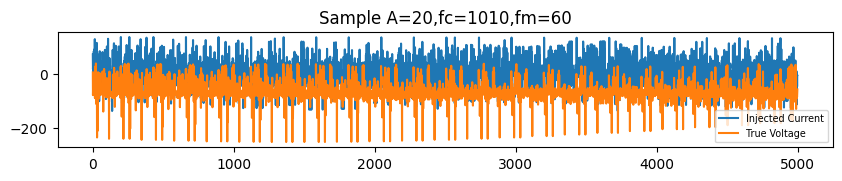

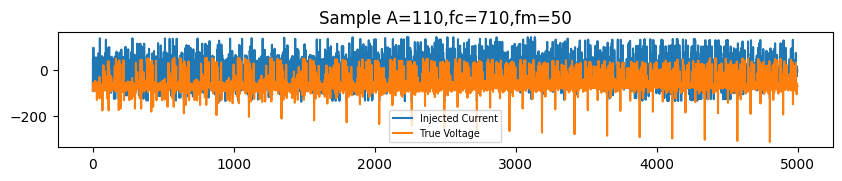

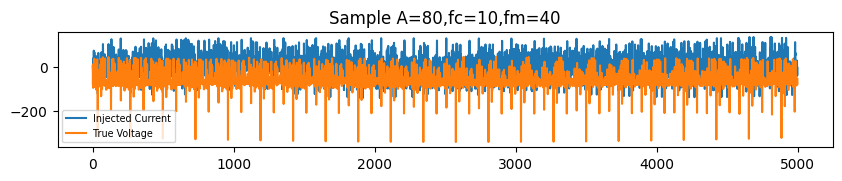

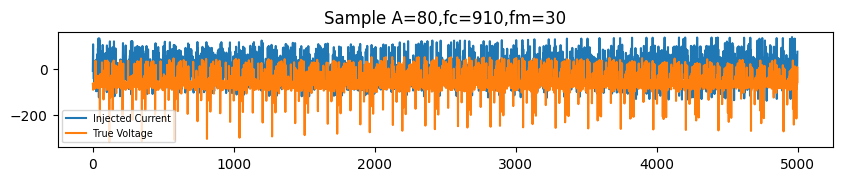

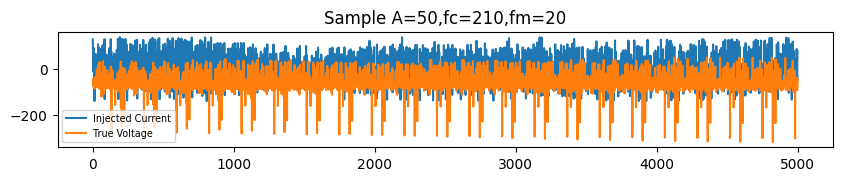

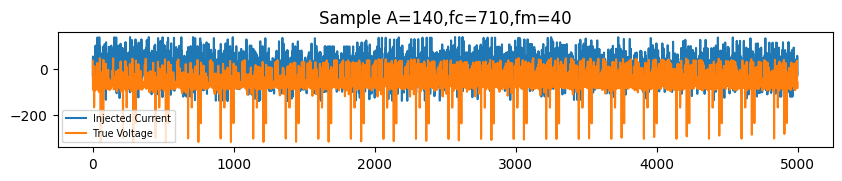

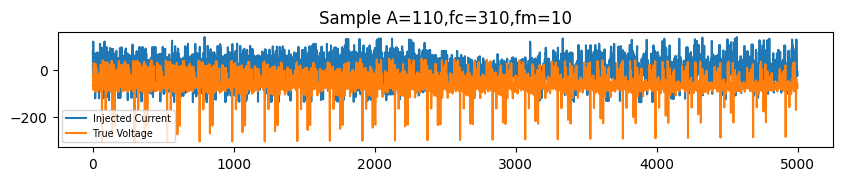

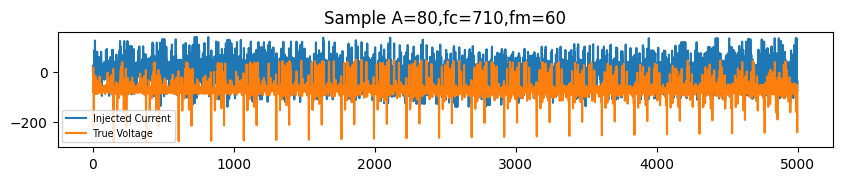

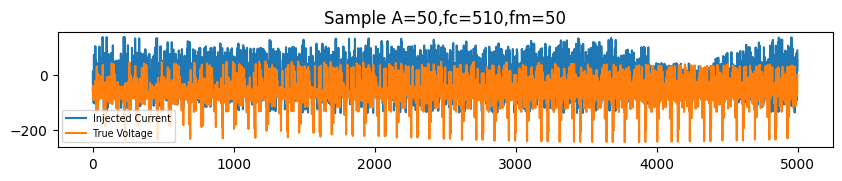

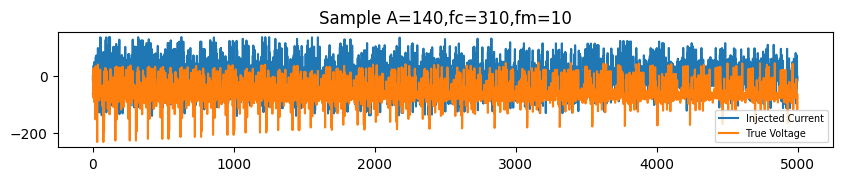

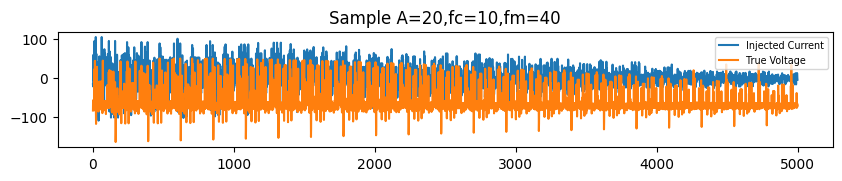

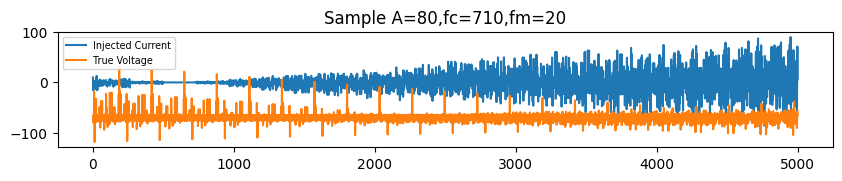

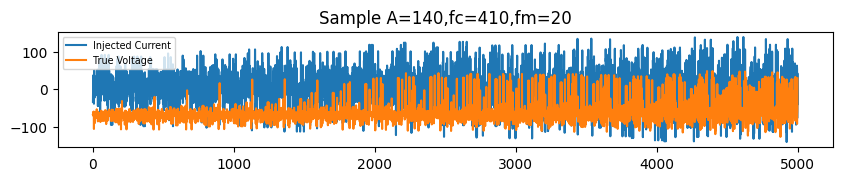

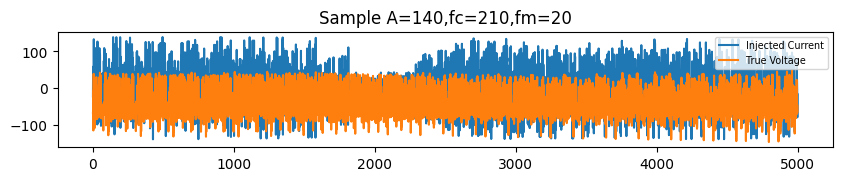

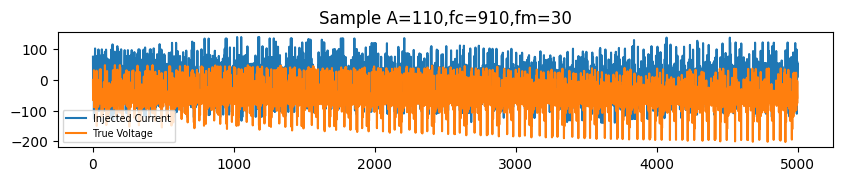

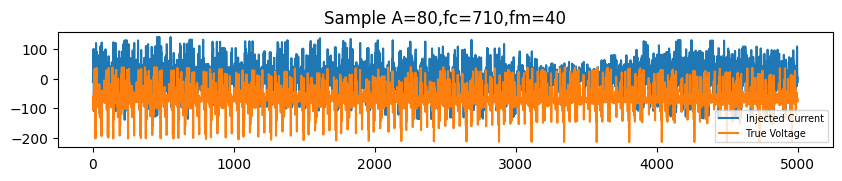

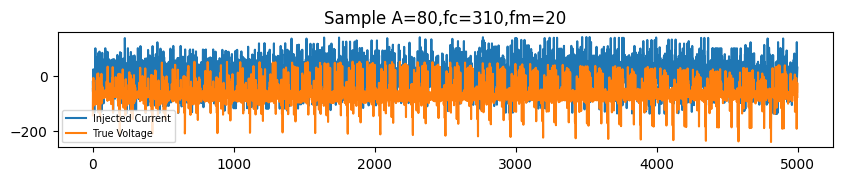

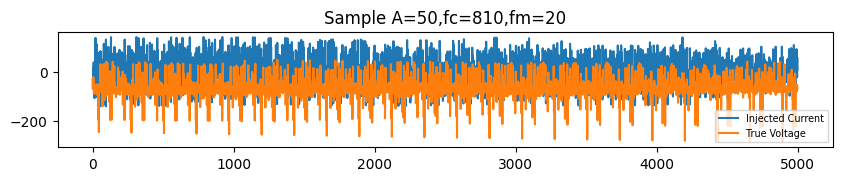

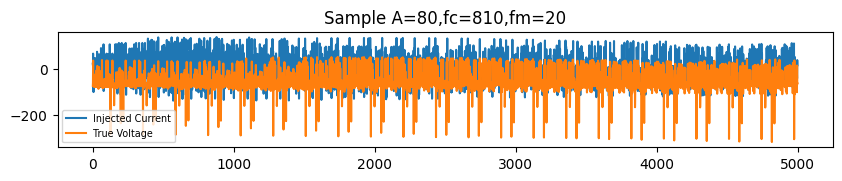

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x2b3dd26e17f0>>
Traceback (most recent call last):
  File "/home/kerwick.a/KFold_Neural_Operator/.pytorch_venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


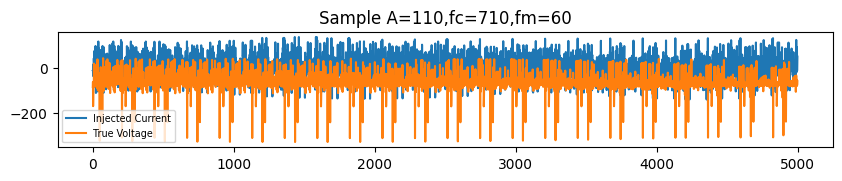

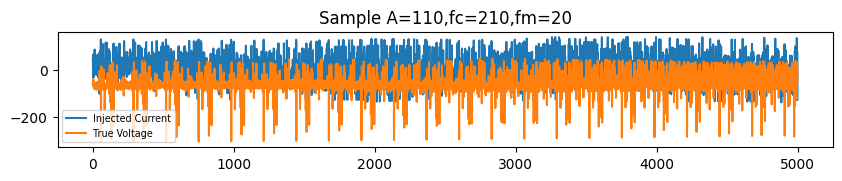

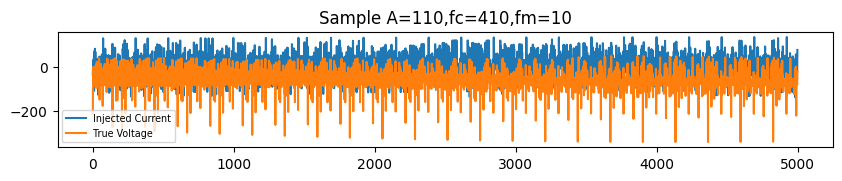

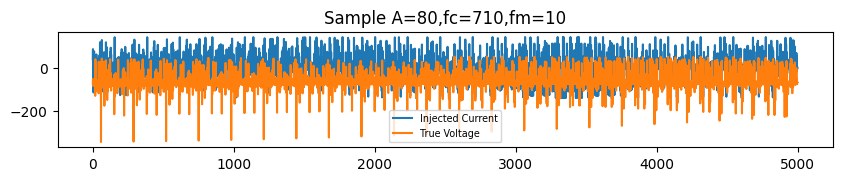

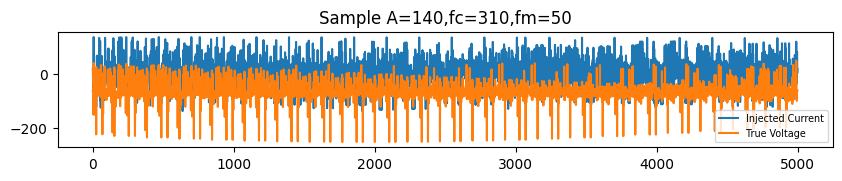

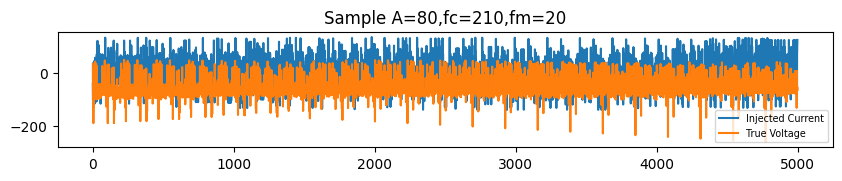

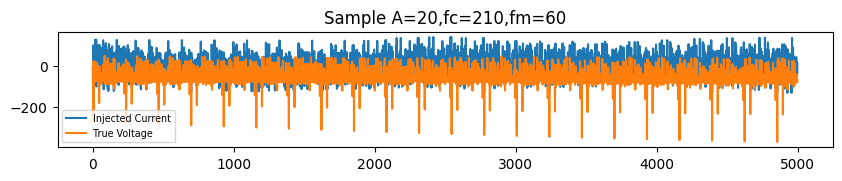

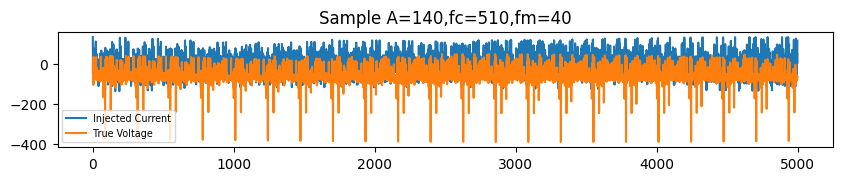

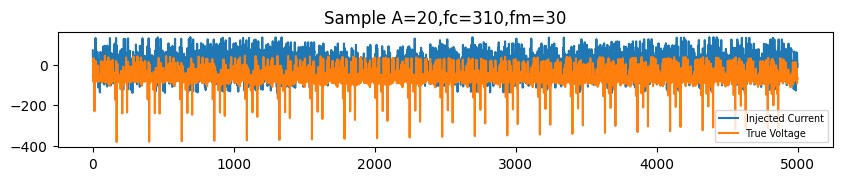

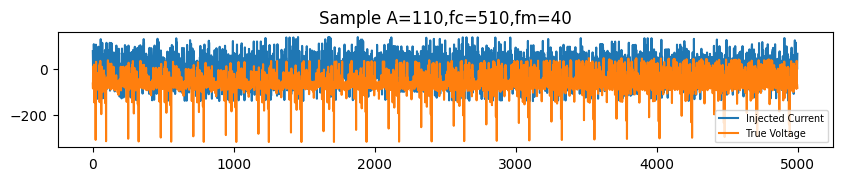

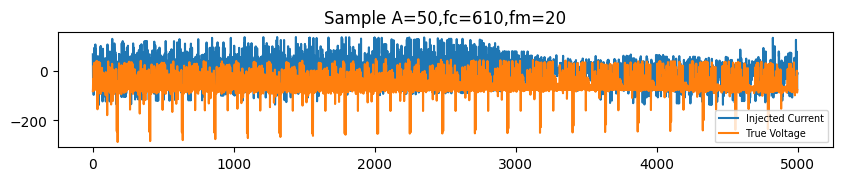

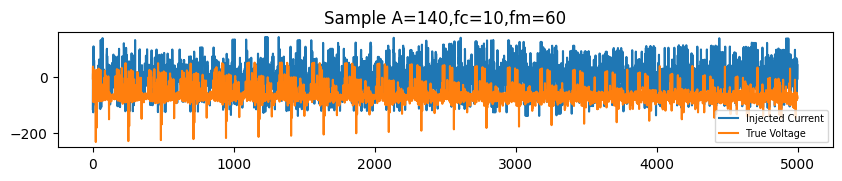

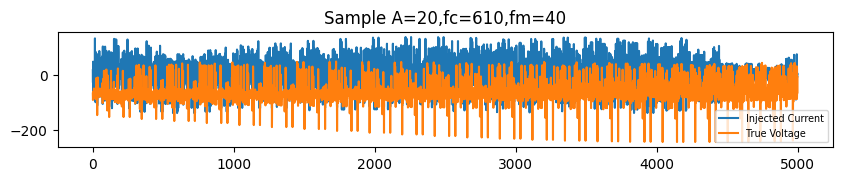

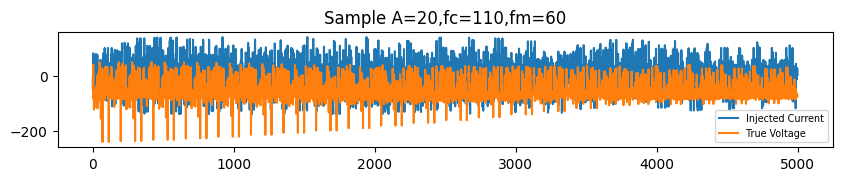

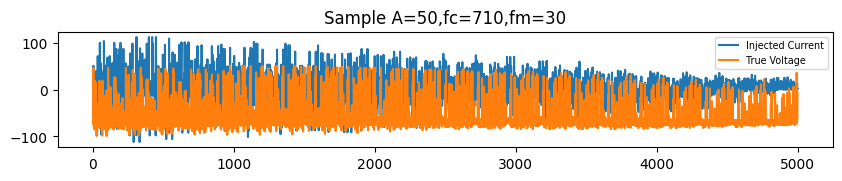

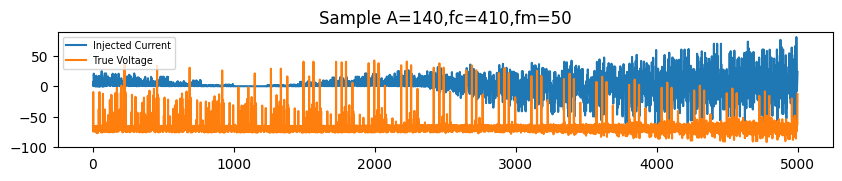

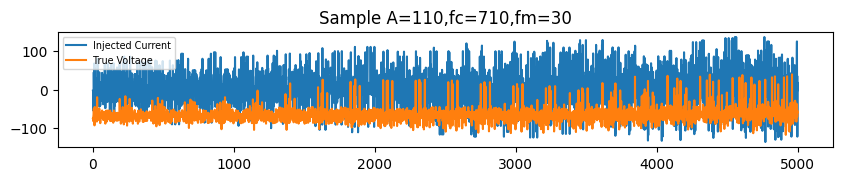

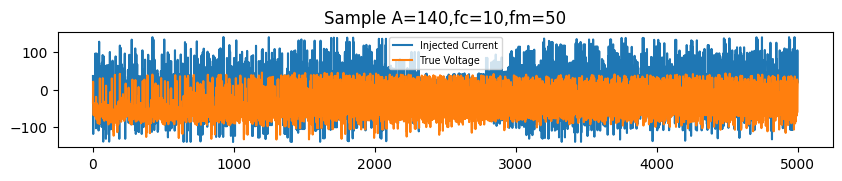

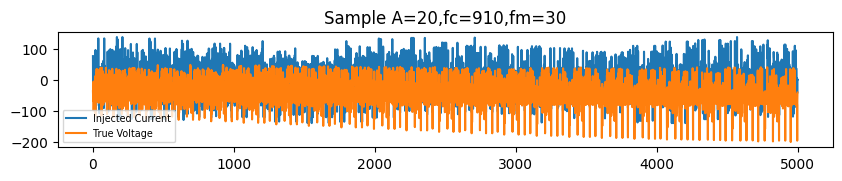

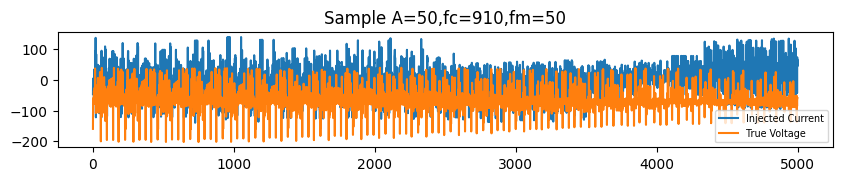

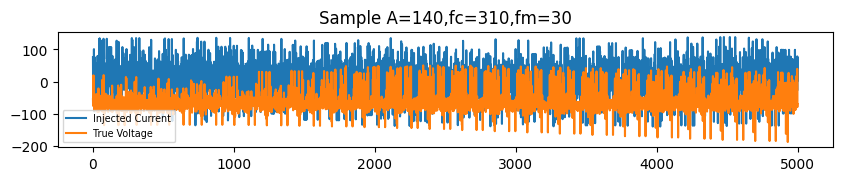

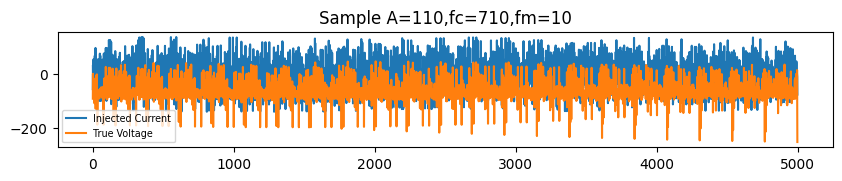

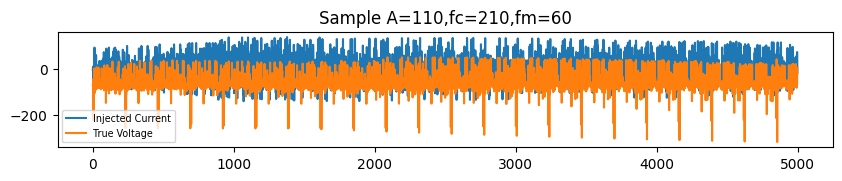

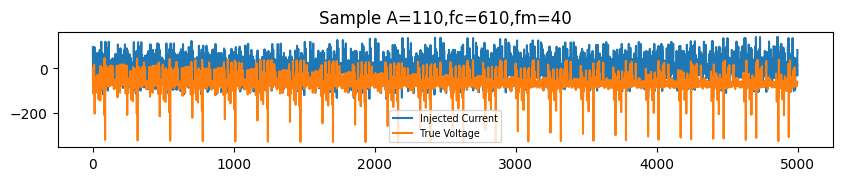

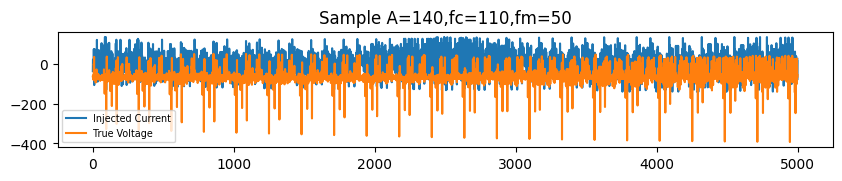

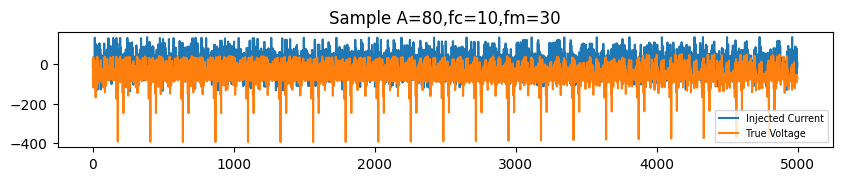

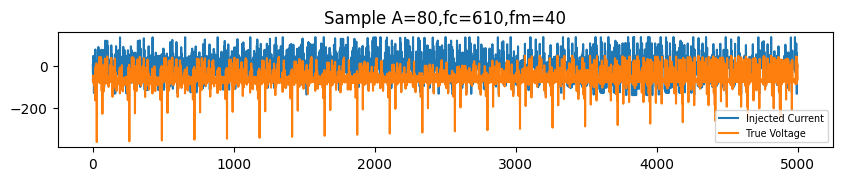

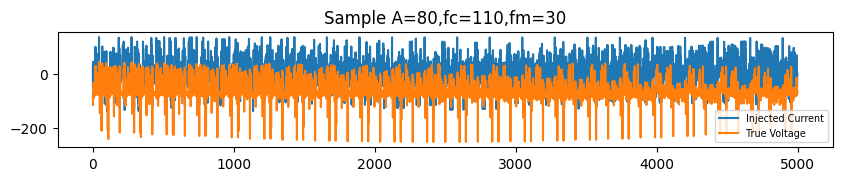

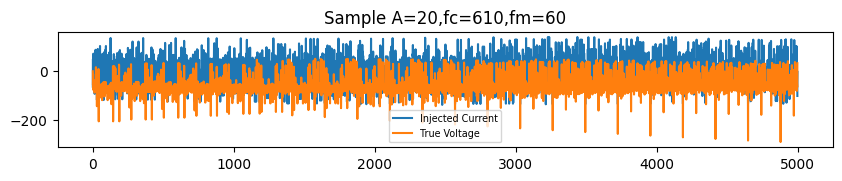

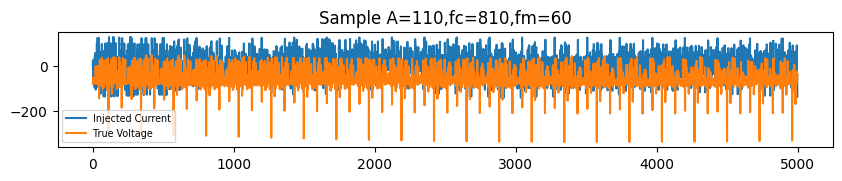

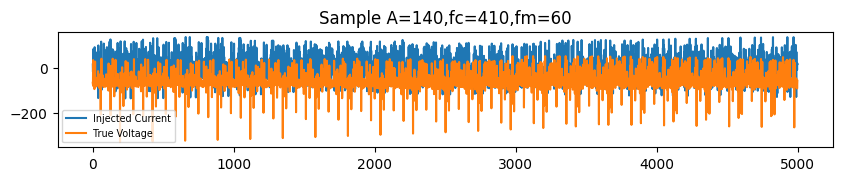

KeyboardInterrupt: 

In [37]:
for i in range(len(train_intervals) - 1):
    start, end = train_intervals[i], train_intervals[i + 1]
    plt.figure(figsize=(10,1.5))
    plt.plot(u_train[start:end,3],label='Injected Current')
    plt.plot(y_train[start:end],label='True Voltage')
    plt.legend(fontsize='x-small')
    plt.title(f'Sample A={p_train[i][0]},fc={p_train[i][1]},fm={p_train[i][2]}')
    #plt.ylim([-0.1,1.1])
    plt.show()

In [ ]:
u_train.shape

In [ ]:
# u = u[0].T
# y = y[0].T

In [ ]:
#u.shape

In [ ]:
# u_train = u[:4000]
# u_test = u[4000:]
# y_train = y[:4000]
# y_test = y[4000:]

#### 2) Instantiate, train & test the network
Parameters are mostly the same as in Herbert Jaeger's original Matlab code. 

In [ ]:
u_train.shape

In [ ]:
u_train.shape[1:]

In [ ]:
esn = ESN(n_inputs = u.shape[1],
          n_outputs = y.shape[1],
          n_reservoir = 200,
          spectral_radius = 0.25,
          sparsity = 0.95,
          noise = 0.001,
#           input_shift = [0,0],
#           input_scaling = [0.01, 3],
#           teacher_scaling = 1.12,
#           teacher_shift = -0.7,
          #out_activation = np.tanh,
          #inverse_out_activation = np.arctanh,
          random_state = random_state,
          silent = False)

pred_train = esn.fit(u_train,y_train)

print("test error:")
pred_test = esn.predict(u_test)
print(np.sqrt(np.mean((pred_test - y_test)**2)))

#### 3) Plots
First, a look at the control signal, the target signal and the output of the model both during training and during testing.

In [ ]:
u_train.shape

In [ ]:
u_train[:100,3]

In [ ]:
for i in range(len(train_intervals) - 1):
    start, end = train_intervals[i], train_intervals[i + 1]
    plt.figure(figsize=(10,1.5))
    plt.plot(u_train[start:end,3],label='Injected Current')
    plt.plot(y_train[start:end],label='True Voltage')
    plt.legend(fontsize='x-small')
    plt.title(f'Sample A={p_train[i][0]},fc={p_train[i][1]},fm={p_train[i][2]}')
    #plt.ylim([-0.1,1.1])
    plt.show()

In [ ]:
for i in range(len(train_intervals) - 1):
    start, end = train_intervals[i], train_intervals[i + 1]
    plt.figure(figsize=(10,1.5))
    plt.plot(u_train[start:end,3],label='Injected Current')
    plt.plot(y_train[start:end],label='True Voltage')
    plt.plot(pred_train[start:end],label='Predicted Voltage')
    plt.legend(fontsize='x-small')
    plt.title(f'training A={p_train[i][0]},fc={p_train[i][1]},fm={p_train[i][2]}')
    #plt.ylim([-0.1,1.1])
    plt.show()

In [ ]:
for i in range(len(test_intervals) - 1):
    start, end = test_intervals[i], test_intervals[i + 1]
    plt.figure(figsize=(10,1.5))
    plt.plot(u_test[start:end,3],label='Injected Current')
    plt.plot(y_test[start:end],label='True Voltage')
    plt.plot(pred_test[start:end],label='Predicted Voltage')
    plt.legend(fontsize='x-small')
    plt.title(f'training A={p_test[i][0]},fc={p_test[i][1]},fm={p_test[i][2]}')
    #plt.ylim([-0.1,1.1])
    plt.show()

In [ ]:
plt.figure(figsize=(10,1.5))
plt.plot(u_train[:,3],label='Injected Current')
plt.plot(y_train,label='True Voltage')
plt.plot(pred_train,label='Predicted Voltage')
plt.legend(fontsize='x-small')
plt.title('training (excerpt)')
#plt.ylim([-0.1,1.1])
plt.show()

#window_test = range(1000)
plt.figure(figsize=(10,1.5))
plt.plot(u_test[:,3],label='Injected Current')
plt.plot(y_test,label='True Voltage')
plt.plot(pred_test,label='Model Voltage')
plt.legend(fontsize='x-small')
plt.title('test (excerpt)')
#plt.ylim([-0.1,1.1]);
plt.show()

In [ ]:
window_tr = range(int(len(y_train)/4),int(len(y_train)/4+2000))
plt.figure(figsize=(10,1.5))
plt.plot(u_train[window_tr,1],label='control')
plt.plot(y_train[window_tr],label='target')
plt.plot(pred_train[window_tr],label='model')
plt.legend(fontsize='x-small')
plt.title('training (excerpt)')
plt.ylim([-0.1,1.1])
plt.show()

window_test = range(1000)
plt.figure(figsize=(10,1.5))
plt.plot(u_test[window_test,1],label='control')
plt.plot(y_test[window_test],label='target')
plt.plot(pred_test[window_test],label='model')
plt.legend(fontsize='x-small')
plt.title('test (excerpt)')
plt.ylim([-0.1,1.1]);
plt.show()

In [ ]:
window_tr = range(int(len(train_output)/4),int(len(train_output)/4+2000))
plt.figure(figsize=(10,1.5))
plt.plot(train_ctrl[window_tr,1],label='control')
plt.plot(train_output[window_tr],label='target')
plt.plot(pred_train[window_tr],label='model')
plt.legend(fontsize='x-small')
plt.title('training (excerpt)')
plt.ylim([-0.1,1.1])
plt.show()

window_test = range(2000)
plt.figure(figsize=(10,1.5))
plt.plot(test_ctrl[window_test,1],label='control')
plt.plot(test_output[window_test],label='target')
plt.plot(pred_test[window_test],label='model')
plt.legend(fontsize='x-small')
plt.title('test (excerpt)')
plt.ylim([-0.1,1.1]);
plt.show()

What we see is that we can't see much, except that the amplitude is systematically too small (any ideas why that is?).

So let's look at a few spectrograms to see how the frequency spectrum of these signals changes over time.

In [ ]:
def draw_spectogram(data):
    plt.specgram(data,Fs=4,NFFT=256,noverlap=150,cmap=plt.cm.bone,detrend=lambda x:(x-0.5))
    plt.gca().autoscale('x')
    plt.ylim([0,0.5])
    plt.ylabel("freq")
    plt.yticks([])
    plt.xlabel("time")
    plt.xticks([])

plt.figure(figsize=(7,1.5))
draw_spectogram(y_train.flatten())
plt.title("training: target")
plt.show()
plt.figure(figsize=(7,1.5))
draw_spectogram(pred_train.flatten())
plt.title("training: model")
plt.show()

plt.figure(figsize=(3,1.5))
draw_spectogram(y_test.flatten())
plt.title("test: target")
plt.show()
plt.figure(figsize=(3,1.5))
draw_spectogram(pred_test.flatten())
plt.title("test: model")
plt.show()

It's a frequency generator!